#     CMP5130 - MACHINE LEARNING AND PATTERN RECOGNITION
##    HOMEWORK-1

## SENIH CERIT 

**Naive Bayes Classifier on Abalone Dataset**

**1. Libraries (Just for calculations and plotting)**

In [1]:
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import itertools

**2. Dataset Import**

In [2]:
column_names = ["Sex","Length","Diameter","Height","Whole Weight","Shucked Weight","Viscera Weight","Shell Weight", "y"]
data = pd.read_csv('abalone_dataset.txt',sep="\t",names=column_names)

**3. General Data Overview**

In [3]:
data

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,y
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,3
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,1
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,2
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,2
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,1
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,2
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,2
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,2
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,2


**4. Randomly Divided into 2 part: Train and Validation**

In [4]:
def split_train_and_validation(data,n):
    train       = data.sample(n=n)
    validation  = data.drop(train.index)
    
    return train,validation

In [5]:
train_100, validation_100  = split_train_and_validation(data,n=100)
train_1000,validation_1000 = split_train_and_validation(data,n=1000)

**5. Calculation of Likelihoods and Prior(For different outputs: Young-MiddleAged-Old)**

In [6]:
def calculate_y_prior(train):
    y_prior = {
        1: 0,
        2: 0,
        3: 0
    }
    
    counts = train["y"].value_counts(ascending=True)
                
    total_num = len(train)
    y_prior[1] = round((counts[1]/total_num), 4) 
    y_prior[2] = round((counts[2]/total_num), 4) 
    y_prior[3] = round((counts[3]/total_num), 4) 
    
    return y_prior        

In [7]:
def calculate_sex_likelihoods(train):
    sex_likelihoods = {
      "F": [0,0,0,0],
      "I": [0,0,0,0],
      "M": [0,0,0,0]
    }

    for i in range(len(train)):
        for j in range(1,4):
            if(train.iat[i,0]=="F" and train.iat[i,8]==j): 
                sex_likelihoods["F"][j] += 1
            elif(train.iat[i,0]=="I" and train.iat[i,8]==j): 
                sex_likelihoods["I"][j] += 1
            elif(train.iat[i,0]=="M" and train.iat[i,8]==j): 
                sex_likelihoods["M"][j] += 1

    y_numbers = train['y'].value_counts(ascending=True)

    array = [0,y_numbers[1],y_numbers[2],y_numbers[3]]
    for i in range(1,4):
        sex_likelihoods["F"][i] = round((sex_likelihoods["F"][i]/array[i]),4)
        sex_likelihoods["I"][i] = round((sex_likelihoods["I"][i]/array[i]),4)
        sex_likelihoods["M"][i] = round((sex_likelihoods["M"][i]/array[i]),4)

    return sex_likelihoods

In [8]:
def calculate_train_values(train):
    train_values = {
        "length"    : { 1: [], 2: [], 3: [], "mean":[0,0,0,0], "std":[0,0,0,0]},
        "diameter"  : { 1: [], 2: [], 3: [], "mean":[0,0,0,0], "std":[0,0,0,0]},
        "height"    : { 1: [], 2: [], 3: [], "mean":[0,0,0,0], "std":[0,0,0,0]},
        "whole_w"   : { 1: [], 2: [], 3: [], "mean":[0,0,0,0], "std":[0,0,0,0]},
        "shucked_w" : { 1: [], 2: [], 3: [], "mean":[0,0,0,0], "std":[0,0,0,0]},
        "viscera_w" : { 1: [], 2: [], 3: [], "mean":[0,0,0,0], "std":[0,0,0,0]},
        "shell_w"   : { 1: [], 2: [], 3: [], "mean":[0,0,0,0], "std":[0,0,0,0]}
    }

    keys = [] 
    for key in train_values.keys(): 
        keys.append(key) 

    for i in range(len(train)):
        for j in range(1,4):
            if(train.iat[i,8]==j): 
                for index in range(len(keys)):
                    train_values[keys[index]][j].append(train.iat[i,(index+1)])
    for i in range(1,4):
        for index in range(len(keys)):
            train_values[keys[index]]["mean"][i] = round((np.mean(train_values[keys[index]][i])),4)
            train_values[keys[index]]["std"][i]  = round((np.std(train_values[keys[index]][i])),4)   
    return train_values,keys

**6. Probability Density Function**

In [9]:
def calculate_probability_density(num,mean,std):
    equation  = (1 / (mt.sqrt(2*mt.pi)*std)) * mt.exp(-(mt.pow(num-mean,2))/(2*mt.pow(std,2)))
    
    return round((equation),4) 

**7. Prediction with Gaussian**

In [10]:
def predict_gaussian(test,sex_likelihoods,train_values,y_prior,keys):
    
    predictions=[]
    for row in range(len(test)):
        elementPrediction= [0,1,1,1]

        for i in range(1,4):
            if  (test.iat[row,0] == "M"): elementPrediction[i] *= sex_likelihoods["M"][i]
            elif(test.iat[row,0] == "I"): elementPrediction[i] *= sex_likelihoods["I"][i]
            elif(test.iat[row,0] == "F"): elementPrediction[i] *= sex_likelihoods["F"][i]

            for index in range(len(keys)):
                elementPrediction[i] *= calculate_probability_density(test.iat[row,index+1],train_values[keys[index]]["mean"][i],
                                                          train_values[keys[index]]["std"][i])
            elementPrediction[i] *= y_prior[i]
            elementPrediction[i] = round((elementPrediction[i]),4)
        predictions.append(elementPrediction.index(max(elementPrediction)))
        
    return predictions

**8. Result and Create Confusion Matrix**

In [11]:
def result(predictions,validation):
    confusion_matrix = [[0,0,0],[0,0,0],[0,0,0]]
    
    if(len(predictions) != len(validation)):
        print("Length is not true")
    else:
        for i in range(len(validation)):
            for item in range(1,4):
                if(validation.iat[i,8] == item):
                    confusion_matrix[item-1][predictions[i]-1] +=1
    true_classification = confusion_matrix[0][0] + confusion_matrix[1][1] + confusion_matrix[2][2]
    miss_classification = len(validation) - true_classification
    accuracy            = true_classification / len(validation)
    print("confusion matrix: ",confusion_matrix)
    print("total correct classification : ",true_classification)
    print("total missclassification  : ",miss_classification)
    print("accuracy  : ",accuracy)
    plot(confusion_matrix)
    
    return confusion_matrix

**9. Plotting Confusion Matrix**

In [12]:
def plot(confusion_matrix):
    confusion_matrix = np.array(confusion_matrix)

    
    classes = ["Young","MiddleAged", "Old"]
    
    plt.figure(figsize=(8, 6))

    plt.imshow(confusion_matrix,interpolation="nearest",cmap=plt.cm.Greys)
    #plt.title('Confusion Matrix')
    
    plt.colorbar()
    
    tickMarks = np.arange(len(classes))
    plt.xticks(tickMarks, classes, rotation=45)
    plt.yticks(tickMarks, classes)

    
    thresh = confusion_matrix.max() / 2
    x = confusion_matrix.shape[0]
    y = confusion_matrix.shape[1]
    
    plt.rcParams.update({'font.size': 14})
    for i, j in itertools.product(range(x), range(y)):
        plt.text(j,i, format(confusion_matrix[i,j], 'd'), ha="center", va="baseline",
                color="red" if confusion_matrix[i,j] > thresh else "red")
    
    plt.tight_layout()
    plt.ylabel('Real Label')
    plt.xlabel('Predicted Label')
    
    print("\nConfusion Matrix:")
    print(confusion_matrix)
    
    plt.show()
    

**10. Main Function of Gaussian (Normal) Equation**

In [13]:
def gaussian_distribution(train,validation,option):    
    
    y_prior = calculate_y_prior(train)
    sex_likelihoods = calculate_sex_likelihoods(train)
    train_values,keys = calculate_train_values(train)
    
    if(option == "Validation"): predict_set = validation
    elif(option == "Train"): predict_set = train
        
    predictions = predict_gaussian(predict_set,sex_likelihoods,train_values,y_prior,keys)
    confusion_matrix = result(predictions,predict_set)
    
    return confusion_matrix

**11. My Results for 1st Question**

***a. 100 sample for Training Set and rest is Validation Set.***

Validation Results

confusion matrix:  [[721, 93, 4], [469, 1267, 584], [56, 448, 435]]
total correct classification :  2423
total missclassification  :  1654
accuracy  :  0.5943095413294088

Confusion Matrix:
[[ 721   93    4]
 [ 469 1267  584]
 [  56  448  435]]


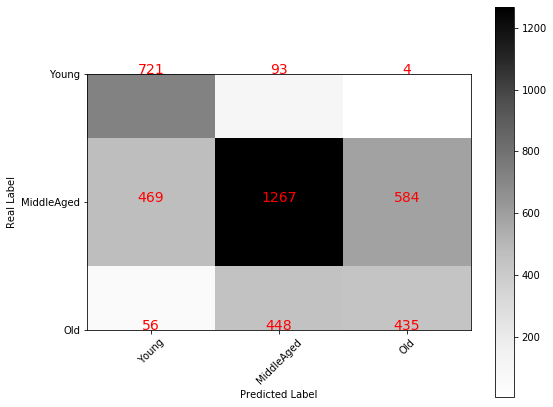

In [14]:
confusion_100_valid = gaussian_distribution(train_100,validation_100,"Validation")

Train Results

confusion matrix:  [[17, 4, 0], [12, 34, 12], [3, 11, 7]]
total correct classification :  58
total missclassification  :  42
accuracy  :  0.58

Confusion Matrix:
[[17  4  0]
 [12 34 12]
 [ 3 11  7]]


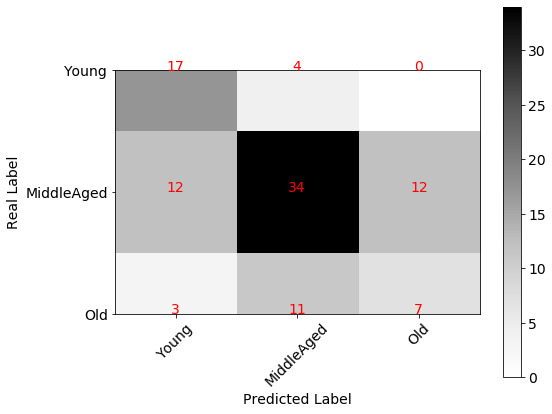

In [15]:
confusion_100_train =  gaussian_distribution(train_100,validation_100,"Train")

***b. 1000 sample for Training Set and rest is Validation Set***


Validation Results

confusion matrix:  [[531, 83, 7], [331, 862, 642], [44, 298, 379]]
total correct classification :  1772
total missclassification  :  1405
accuracy  :  0.5577588920365124

Confusion Matrix:
[[531  83   7]
 [331 862 642]
 [ 44 298 379]]


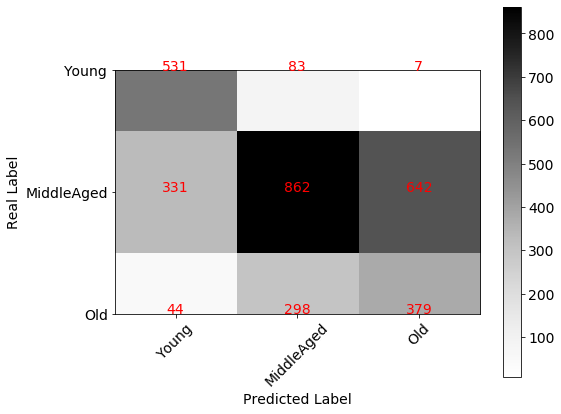

In [16]:
confusion_1000_valid = gaussian_distribution(train_1000,validation_1000,"Validation")

Train Results

confusion matrix:  [[196, 21, 1], [105, 255, 183], [11, 96, 132]]
total correct classification :  583
total missclassification  :  417
accuracy  :  0.583

Confusion Matrix:
[[196  21   1]
 [105 255 183]
 [ 11  96 132]]


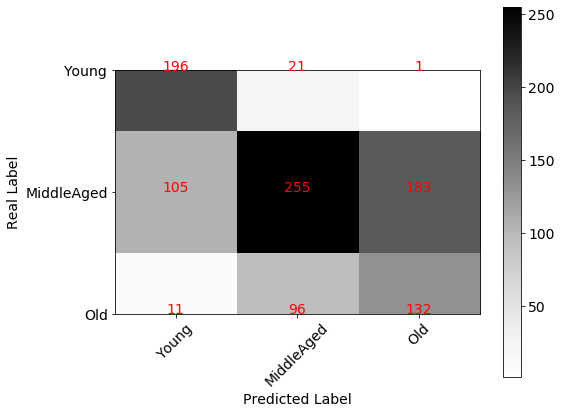

In [17]:
confusion_1000_train = gaussian_distribution(train_1000,validation_1000,"Train")

In [18]:
true_100 = confusion_100_valid[0][0] + confusion_100_valid[1][1] + confusion_100_valid[2][2] + confusion_100_train[0][0] + confusion_100_train[1][1] + confusion_100_train[2][2]
miss_100 = len(data) - true_100

true_1000 = confusion_1000_valid[0][0] + confusion_1000_valid[1][1] + confusion_1000_valid[2][2] + confusion_1000_train[0][0] + confusion_1000_train[1][1] + confusion_1000_train[2][2]
miss_1000 = len(data) - true_1000

Accuracy for 100 and 1000

In [19]:
accuracy_100_gaussian = round((true_100 / (true_100 + miss_100)),4)
accuracy_1000_gaussian = round((true_1000 / (true_1000 + miss_1000)),4)

In [20]:
print("For both Train and Validation\n\nAccuracy of 100 samples:", accuracy_100_gaussian)
print("Accuracy of 1000 samples:", accuracy_1000_gaussian)

For both Train and Validation

Accuracy of 100 samples: 0.594
Accuracy of 1000 samples: 0.5638


### 2. Question - Histogram Estimator 

**1. H sizes**
- Length: 0.3
- Diameter: 0.25
- Height: 0.5
- Whole Weight: 0.5
- Shucked Weight: 0.5
- Viscera Weight: 0.5
- Shell Weight: 0.5


In [21]:
def initialize_h_train_values():
    h_sizes = {
        "Length"    : 0.3,
        "Diameter"  : 0.25,
        "Height"    : 0.5,
        "Whole Weight"   : 0.5,
        "Shucked Weight" : 0.5,
        "Viscera Weight" : 0.5,
        "Shell Weight"   : 0.5
    }

    train_values = {
        "Length"    : { 0 : { 1: 0, 2: 0, 3: 0} },
        "Diameter"  : { 0 : { 1: 0, 2: 0, 3: 0} },
        "Height"    : { 0 : { 1: 0, 2: 0, 3: 0} },
        "Whole Weight"   : { 0 : { 1: 0, 2: 0, 3: 0} },
        "Shucked Weight" : { 0 : { 1: 0, 2: 0, 3: 0} },
        "Viscera Weight" : { 0 : { 1: 0, 2: 0, 3: 0} },
        "Shell Weight"   : { 0 : { 1: 0, 2: 0, 3: 0} }
    }

    keys = [] 
    for key in train_values.keys(): 
        keys.append(key) 

    for key in keys:    
        temp = h_sizes[key]
        while(temp < data[key].max()):
            train_values[key][temp] = { 1: 0, 2: 0, 3: 0}
            temp += h_sizes[key]
            
    return h_sizes,train_values,keys

**2. Fill h sizes array with values.(We distribute these appropriate their ranges)**

In [22]:
def fill_train_values(train, train_values, keys):
    for column in keys:
        element_range = [] 
        for key in train_values[column].keys(): 
            element_range.append(key) 

        for index in range(len(train)):
            number = train.iat[index,1] 
            y = train.iat[index,8]

            if(number > element_range[-1]):
                train_values[column][element_range[-1]][y] +=1
            else:
                for i in range(len(element_range)-1):
                    if(number < element_range[i+1]):
                        train_values[column][element_range[i]][y] +=1
                        break
    return train_values

**3. For calculation of Histogram Value, we need to number of values which are in same bin**

In [23]:
def get_number_of_same_bin(number,train_values,key,y):
    element_range = [] 
    for z in train_values[key].keys(): 
        element_range.append(z)     
    
    if(number >= element_range[-1]):
        return train_values[key][element_range[-1]][y]
    else:
        for i in range(len(element_range)-1):
            if(number < element_range[i+1]):
                return train_values[key][element_range[i]][y]


**4. Histogram Value Calculation**

In [24]:
def calculate_histogram_value(number_same_bin, total_number,h_size):
    return round((number_same_bin / (total_number * h_size)),4)

**5. Predictions and max value of output will be passed**

In [25]:
def predict_histogram(test, instance_size, sex_likelihoods, train_values, y_prior, keys, h_sizes):
    
    predictions=[]
    
    for row in range(len(test)):
        elementPrediction= [0,1,1,1]

        for i in range(1,4):
            if  (test.iat[row,0] == "M"): elementPrediction[i] *= sex_likelihoods["M"][i]
            elif(test.iat[row,0] == "I"): elementPrediction[i] *= sex_likelihoods["I"][i]
            elif(test.iat[row,0] == "F"): elementPrediction[i] *= sex_likelihoods["F"][i]

            for index in range(len(keys)):
                number_of_same_bin = get_number_of_same_bin(test.iat[row,index+1],train_values,keys[index],i)
                #print(number_of_same_bin)
                #print(instance_size)
                #print(h_sizes[keys[index]])
                elementPrediction[i] *= calculate_histogram_value(number_of_same_bin, instance_size, h_sizes[keys[index]])
            elementPrediction[i] *= y_prior[i]
            elementPrediction[i] = round(elementPrediction[i],4)
        predictions.append(elementPrediction.index(max(elementPrediction)))
    return predictions

**6. Main Function**

In [26]:
def histogram_estimator(train,validation,option):    
    
    y_prior = calculate_y_prior(train)
    sex_likelihoods = calculate_sex_likelihoods(train)
    
    h_sizes, train_values, keys = initialize_h_train_values()
    train_values = fill_train_values(train, train_values, keys)
    
    if(option == "Validation"): test = validation
    elif(option == "Train"): test = train
    
    predictions = predict_histogram(test, len(train), sex_likelihoods, train_values, y_prior, keys, h_sizes)
    confusion_matrix = result(predictions,test)
    
    return confusion_matrix
    

**7. My Results for 2nd Question**

***a. 100 sample for Training Set and rest is Validation Set.***

Validation Results

confusion matrix:  [[1, 532, 285], [0, 1381, 939], [0, 415, 524]]
total correct classification :  1906
total missclassification  :  2171
accuracy  :  0.4675006131959774

Confusion Matrix:
[[   1  532  285]
 [   0 1381  939]
 [   0  415  524]]


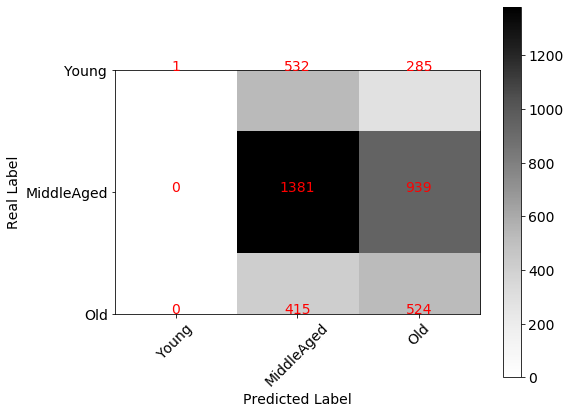

In [27]:
confusion_100_valid = histogram_estimator(train_100,validation_100,"Validation")

Train Results

confusion matrix:  [[0, 14, 7], [0, 40, 18], [0, 13, 8]]
total correct classification :  48
total missclassification  :  52
accuracy  :  0.48

Confusion Matrix:
[[ 0 14  7]
 [ 0 40 18]
 [ 0 13  8]]


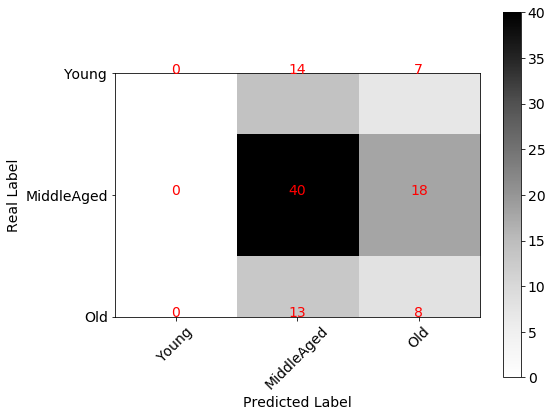

In [28]:
confusion_100_train = histogram_estimator(train_100,validation_100,"Train")

***b. 1000 sample for Training Set and rest is Validation Set.***

Validation Results

confusion matrix:  [[321, 133, 167], [166, 925, 744], [15, 310, 396]]
total correct classification :  1642
total missclassification  :  1535
accuracy  :  0.516839785961599

Confusion Matrix:
[[321 133 167]
 [166 925 744]
 [ 15 310 396]]


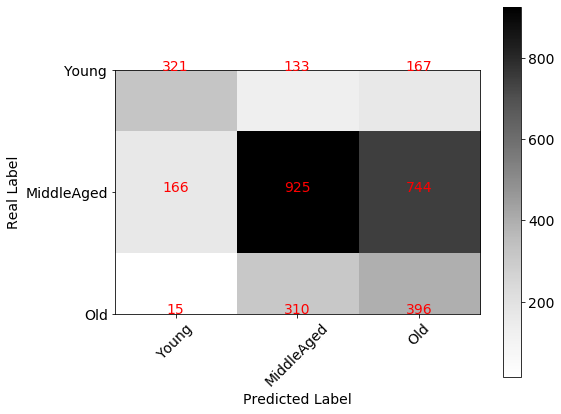

In [29]:
confusion_1000_valid = histogram_estimator(train_1000,validation_1000,"Validation")

Train Results

confusion matrix:  [[118, 42, 58], [60, 277, 206], [8, 96, 135]]
total correct classification :  530
total missclassification  :  470
accuracy  :  0.53

Confusion Matrix:
[[118  42  58]
 [ 60 277 206]
 [  8  96 135]]


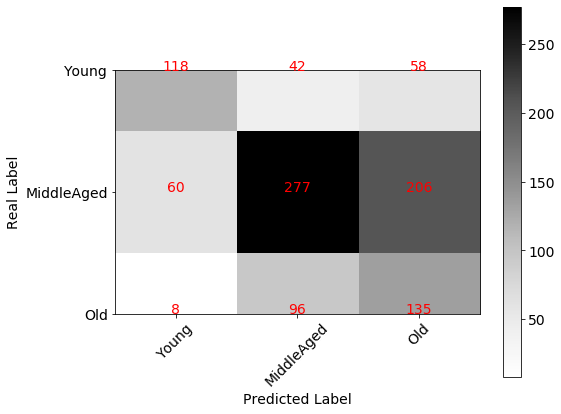

In [30]:
confusion_1000_train =  histogram_estimator(train_1000,validation_1000,"Train")

In [31]:
true_100 = confusion_100_valid[0][0] + confusion_100_valid[1][1] + confusion_100_valid[2][2] + confusion_100_train[0][0] + confusion_100_train[1][1] + confusion_100_train[2][2]
miss_100 = len(data) - true_100

true_1000 = confusion_1000_valid[0][0] + confusion_1000_valid[1][1] + confusion_1000_valid[2][2] + confusion_1000_train[0][0] + confusion_1000_train[1][1] + confusion_1000_train[2][2]
miss_1000 = len(data) - true_1000

Accuracy for 100 and 1000

In [32]:
accuracy_100_histogram = round((true_100 / (true_100 + miss_100)),4)
accuracy_1000_histogram = round((true_1000 / (true_1000 + miss_1000)),4)

In [33]:
print("For both Train and Validation\n\nAccuracy of 100 samples:", accuracy_100_histogram)
print("Accuracy of 1000 samples:", accuracy_1000_histogram)

For both Train and Validation

Accuracy of 100 samples: 0.4678
Accuracy of 1000 samples: 0.52
